In [2]:
# Part 1: Initialization and Loading PGN Files

# Import required libraries
import chess
import chess.engine
import chess.pgn
import chess.svg
import subprocess
import os
from PIL import Image
import io
import json
import random
import time
import csv
from IPython.display import display

# Paths to your engines and Maia models
stockfish_path = "/opt/homebrew/bin/stockfish"
maia_model_paths = {
    1100: "maia_weights/maia-1100.pb.gz",
    1200: "maia_weights/maia-1200.pb.gz",
    1300: "maia_weights/maia-1300.pb.gz",
    1400: "maia_weights/maia-1400.pb.gz",
    1500: "maia_weights/maia-1500.pb.gz",
    1600: "maia_weights/maia-1600.pb.gz",
    1700: "maia_weights/maia-1700.pb.gz",
    1800: "maia_weights/maia-1800.pb.gz",
    1900: "maia_weights/maia-1900.pb.gz",
}

# Initialize Stockfish engine
print("Initializing Stockfish engine...")
try:
    stockfish_engine = chess.engine.SimpleEngine.popen_uci(stockfish_path, stderr=subprocess.DEVNULL)
    print("Stockfish engine initialized.")
except Exception as e:
    print(f"Error initializing Stockfish engine: {e}")

# Initialize Maia engines
print("Initializing Maia engines...")
maia_engines = {}
for elo, path in maia_model_paths.items():
    try:
        print(f"Initializing Maia {elo} engine...")
        maia_engines[elo] = chess.engine.SimpleEngine.popen_uci(["lc0", f"--weights={path}"], stderr=subprocess.DEVNULL)
        print(f"Maia {elo} engine initialized.")
    except Exception as e:
        print(f"Error initializing Maia {elo} engine: {e}")


# Function to load games from a PGN file
def load_games_from_pgn(file_path):
    games = []
    with open(file_path, 'r') as pgn_file:
        while True:
            game = chess.pgn.read_game(pgn_file)
            if game is None:
                break
            games.append(game)
    print(f"Loaded {len(games)} games from PGN file {file_path}.")
    return games


# Directory containing PGN files
pgn_directory = "analysis_pgns"
all_games = []

print("Starting to load PGN files...")

for pgn_file in os.listdir(pgn_directory):
    if pgn_file.endswith(".pgn"):
        pgn_file_path = os.path.join(pgn_directory, pgn_file)
        print(f"Loading {pgn_file_path}...")
        all_games.extend(load_games_from_pgn(pgn_file_path))

print(f"Total games loaded: {len(all_games)}")

Initializing Stockfish engine...
Stockfish engine initialized.
Initializing Maia engines...
Initializing Maia 1100 engine...
Maia 1100 engine initialized.
Initializing Maia 1200 engine...
Maia 1200 engine initialized.
Initializing Maia 1300 engine...
Maia 1300 engine initialized.
Initializing Maia 1400 engine...
Maia 1400 engine initialized.
Initializing Maia 1500 engine...
Maia 1500 engine initialized.
Initializing Maia 1600 engine...
Maia 1600 engine initialized.
Initializing Maia 1700 engine...
Maia 1700 engine initialized.
Initializing Maia 1800 engine...
Maia 1800 engine initialized.
Initializing Maia 1900 engine...
Maia 1900 engine initialized.
Starting to load PGN files...
Loading analysis_pgns_test/4c6eS6SH---1969 Petrosian vs. Spassky .pgn...
Loaded 4 games from PGN file analysis_pgns_test/4c6eS6SH---1969 Petrosian vs. Spassky .pgn.
Loading analysis_pgns_test/4S5UuAGn---1986 Karpov vs. Kasparov III.pgn...
Loaded 5 games from PGN file analysis_pgns_test/4S5UuAGn---1986 Karpov v

In [3]:
import chess.pgn

# Function to calculate average error for a position using Stockfish
def calculate_average_error(board, stockfish_engine):
    legal_moves = list(board.legal_moves)
    total_error = 0
    num_moves = len(legal_moves)

    for move in legal_moves:
        board.push(move)
        info = stockfish_engine.analyse(board, chess.engine.Limit(time=0.1))
        eval_score = info["score"].relative.score(mate_score=10000) / 100.0
        total_error += eval_score if board.turn else -eval_score  # Adjust error based on player's turn
        board.pop()

    average_error = total_error / num_moves if num_moves > 0 else 0
    return average_error

# Function to analyze a game using Stockfish and Maia engines
def analyze_with_engines(game, stockfish_engine, maia_engines):
    board = game.board()
    blunders = []

    for move in game.mainline_moves():
        fen_before = board.fen()  # Get FEN before the move
        player = board.turn  # True for White, False for Black

        # Analyze the position before the move
        stockfish_info_before = stockfish_engine.analyse(board, chess.engine.Limit(time=0.1))
        stockfish_eval_before = stockfish_info_before["score"].relative.score(mate_score=10000) / 100.0

        board.push(move)

        # Analyze the position after the move
        stockfish_info_after = stockfish_engine.analyse(board, chess.engine.Limit(time=0.1))
        stockfish_eval_after = stockfish_info_after["score"].relative.score(mate_score=10000) / 100.0
        stockfish_best_move_after = stockfish_info_after["pv"][0] if "pv" in stockfish_info_after else None

        # Determine if the move was a blunder
        if player and (stockfish_eval_after < stockfish_eval_before - 4) or not player and (stockfish_eval_after > stockfish_eval_before + 4):
            maia_suggestions = {}
            board.pop()  # Revert to the position before the blunder
            for elo, maia_engine in maia_engines.items():
                # Analyze the position before the blunder for Maia suggestions
                maia_info = maia_engine.analyse(board, chess.engine.Limit(nodes=1))
                maia_eval = maia_info["score"].relative.score(mate_score=10000) / 100.0
                maia_best_move = maia_info["pv"][0] if "pv" in maia_info else None
                maia_suggestions[elo] = (maia_best_move, maia_eval)
            board.push(move)  # Push the move again to keep the board state

            blunders.append((fen_before, move, stockfish_eval_after, stockfish_best_move_after, maia_suggestions))

    print(f"Analyzed game with {len(blunders)} blunders found.")
    return blunders

# Function to filter the best blunders based on majority agreement and magnitude of evaluation change
def filter_best_blunders(blunders, evaluation_change_threshold=3.0, majority_threshold=0.8):
    filtered_blunders = []

    for fen, move, stockfish_eval, stockfish_best_move, maia_suggestions in blunders:
        move_counts = {}

        # Count how many times each move is suggested by Maia engines above 1300
        for elo, (best_move, maia_eval) in maia_suggestions.items():
            if elo > 1300:
                if best_move in move_counts:
                    move_counts[best_move] += 1
                else:
                    move_counts[best_move] = 1

        # Find the move with the highest count
        if move_counts:
            most_common_move, count = max(move_counts.items(), key=lambda item: item[1])

            # Calculate the agreement ratio
            total_considered = sum(1 for elo in maia_suggestions if elo > 1300)
            agreement_ratio = count / total_considered if total_considered > 0 else 0

            # Calculate the evaluation change
            eval_change = abs(stockfish_eval)

            # Filter based on majority agreement and evaluation change threshold
            if agreement_ratio >= majority_threshold and eval_change >= evaluation_change_threshold and str(move) != str(stockfish_best_move):
                filtered_blunders.append((fen, move, stockfish_eval, most_common_move, maia_suggestions))

    print(f"Filtered blunders down to {len(filtered_blunders)} consistent ones.")
    return filtered_blunders


In [4]:
import csv
import json

# Directory containing PGN files
pgn_directory = "analysis_pgns_test"
all_positions = []

# Function to save results incrementally to CSV
def save_results_to_csv(csv_file_path, data):
    with open(csv_file_path, "a", newline='') as csvfile:
        csvwriter = csv.writer(csvfile)
        for entry in data:
            csvwriter.writerow([
                entry["FEN"], entry["Average Error"], entry["Event"], entry["Move"],
                entry["Best Move"], entry["Player"], entry["To Move"], entry["White"],
                entry["Black"], entry["Round"], entry["Result"], entry["WhiteElo"],
                entry["BlackElo"], entry["Opening"], entry["File"]
            ])

# Function to save results incrementally to JSON
def save_results_to_json(json_file_path, data):
    if os.path.exists(json_file_path):
        with open(json_file_path, "r") as jsonfile:
            json_data = json.load(jsonfile)
    else:
        json_data = {}

    for entry in data:
        event = entry["Event"]
        if event not in json_data:
            json_data[event] = []
        json_data[event].append(entry)

    with open(json_file_path, "w") as jsonfile:
        json.dump(json_data, jsonfile, indent=4)

# Paths to save results
csv_file_path = "positions_with_errors.csv"
json_file_path = "positions_with_errors.json"
csv_file_path_maia = "positions_with_errors_maia.csv"
json_file_path_maia = "positions_with_errors_maia.json"

# Initialize CSV file with headers
with open(csv_file_path, "w", newline='') as csvfile:
    csvwriter = csv.writer(csvfile)
    csvwriter.writerow([
        "FEN", "Average Error", "Event", "Move", "Best Move", "Player",
        "To Move", "White", "Black", "Round", "Result", "WhiteElo",
        "BlackElo", "Opening", "File"
    ])

with open(csv_file_path_maia, "w", newline='') as csvfile:
    csvwriter = csv.writer(csvfile)
    csvwriter.writerow([
        "FEN", "Average Error", "Event", "Move", "Best Move", "Player",
        "To Move", "White", "Black", "Round", "Result", "WhiteElo",
        "BlackElo", "Opening", "File"
    ])

print("Starting analysis of PGN files...")

for pgn_file in os.listdir(pgn_directory):
    if pgn_file.endswith(".pgn"):
        pgn_file_path = os.path.join(pgn_directory, pgn_file)
        print(f"Analyzing {pgn_file_path}...")
        all_games = load_games_from_pgn(pgn_file_path)
        print(f"Loaded {len(all_games)} games from PGN file {pgn_file_path}.")

        # Analyze games without using Maia
        for game in all_games:
            print(f"Analyzing game {game.headers.get('Event', 'Unknown Event')} without Maia...")
            board = game.board()
            node = game
            current_positions = []
            while node.variations:
                move = node.variation(0).move
                fen = board.fen()
                print(f"Analyzing position: {fen}")
                avg_error = calculate_average_error(board, stockfish_engine)

                # Skip moves with average error less than or equal to 3
                if abs(avg_error) <= 3:
                    board.push(move)
                    node = node.variation(0)
                    continue

                stockfish_info = stockfish_engine.analyse(board, chess.engine.Limit(time=0.1))
                best_move = stockfish_info["pv"][0] if "pv" in stockfish_info else None

                # Check for move equality and filter out if they are the same
                if str(move) == str(best_move):
                    print(f"Skipping move {move} as it is the same as the best move {best_move}.")
                    board.push(move)
                    node = node.variation(0)
                    continue

                event_details = {
                    "FEN": fen,
                    "Average Error": avg_error,
                    "Event": game.headers.get("Event", "Unknown Event"),
                    "Move": str(move),
                    "Best Move": str(best_move),
                    "Player": "White" if board.turn else "Black",
                    "To Move": "White" if board.turn else "Black",
                    "White": game.headers.get("White", "Unknown"),
                    "Black": game.headers.get("Black", "Unknown"),
                    "Round": game.headers.get("Round", "Unknown"),
                    "Result": game.headers.get("Result", "*"),
                    "WhiteElo": game.headers.get("WhiteElo", "N/A"),
                    "BlackElo": game.headers.get("BlackElo", "N/A"),
                    "Opening": game.headers.get("Opening", "Unknown Opening"),
                    "File": pgn_file_path
                }
                current_positions.append(event_details)
                try:
                    board.push(move)
                except AssertionError as e:
                    print(f"Error: {e}, move: {move}, position: {board.fen()}")
                    break  # Skip to the next game
                node = node.variation(0)  # Move to the next node in the game tree

                # Debugging print to ensure we are making progress
                print(f"Processed move: {move}, current positions collected: {len(current_positions)}")

            # Save results incrementally
            save_results_to_csv(csv_file_path, current_positions)
            save_results_to_json(json_file_path, current_positions)

            all_positions.extend(current_positions)
            print(f"Finished analyzing game {game.headers.get('Event', 'Unknown Event')} without Maia.")

# Analyze games using Maia
for pgn_file in os.listdir(pgn_directory):
    if pgn_file.endswith(".pgn"):
        pgn_file_path = os.path.join(pgn_directory, pgn_file)
        print(f"Analyzing {pgn_file_path} (with Maia)...")
        all_games = load_games_from_pgn(pgn_file_path)
        print(f"Loaded {len(all_games)} games from PGN file {pgn_file_path}.")

        for game in all_games:
            print(f"Analyzing game {game.headers.get('Event', 'Unknown Event')} with Maia...")
            blunders = analyze_with_engines(game, stockfish_engine, maia_engines)
            filtered_blunders = filter_best_blunders(blunders)
            current_positions = []

            for fen, move, stockfish_eval, best_move, maia_suggestions in filtered_blunders:
                avg_error = calculate_average_error(chess.Board(fen), stockfish_engine)

                # Skip moves with average error less than or equal to 3
                if abs(avg_error) <= 3:
                    continue

                # Check for move equality and filter out if they are the same
                if str(move) == str(best_move):
                    print(f"Skipping move {move} as it is the same as the best move {best_move}.")
                    continue

                event_details = {
                    "FEN": fen,
                    "Average Error": avg_error,
                    "Event": game.headers.get("Event", "Unknown Event"),
                    "Move": str(move),
                    "Best Move": str(best_move),
                    "Player": "White" if chess.Board(fen).turn else "Black",
                    "To Move": "White" if chess.Board(fen).turn else "Black",
                    "White": game.headers.get("White", "Unknown"),
                    "Black": game.headers.get("Black", "Unknown"),
                    "Round": game.headers.get("Round", "Unknown"),
                    "Result": game.headers.get("Result", "*"),
                    "WhiteElo": game.headers.get("WhiteElo", "N/A"),
                    "BlackElo": game.headers.get("BlackElo", "N/A"),
                    "Opening": game.headers.get("Opening", "Unknown Opening"),
                    "File": pgn_file_path
                }

                # Check if best move matches any of the Maia suggestions
                maia_match = False
                for elo, (maia_move, maia_eval) in maia_suggestions.items():
                    if str(maia_move) == str(best_move):
                        maia_match = True
                        break

                if maia_match:
                    current_positions.append(event_details)

                # Debugging print to ensure we are making progress
                print(f"Processed move: {move}, current positions collected: {len(current_positions)}")

            # Save results incrementally
            save_results_to_csv(csv_file_path_maia, current_positions)
            save_results_to_json(json_file_path_maia, current_positions)

            print(f"Finished analyzing game {game.headers.get('Event', 'Unknown Event')} with Maia.")

print("Analysis complete. Results saved incrementally.")


Starting analysis of PGN files...
Analyzing analysis_pgns_test/4c6eS6SH---1969 Petrosian vs. Spassky .pgn...
Loaded 4 games from PGN file analysis_pgns_test/4c6eS6SH---1969 Petrosian vs. Spassky .pgn.
Loaded 4 games from PGN file analysis_pgns_test/4c6eS6SH---1969 Petrosian vs. Spassky .pgn.
Analyzing game FIDE World Championship Match 1969 without Maia...
Analyzing position: rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1
Analyzing position: rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR b KQkq - 0 1
Analyzing position: rnbqkbnr/pp1ppppp/8/2p5/4P3/8/PPPP1PPP/RNBQKBNR w KQkq - 0 2
Analyzing position: rnbqkbnr/pp1ppppp/8/2p5/4P3/5N2/PPPP1PPP/RNBQKB1R b KQkq - 1 2
Analyzing position: rnbqkbnr/pp1p1ppp/4p3/2p5/4P3/5N2/PPPP1PPP/RNBQKB1R w KQkq - 0 3
Analyzing position: rnbqkbnr/pp1p1ppp/4p3/2p5/3PP3/5N2/PPP2PPP/RNBQKB1R b KQkq - 0 3
Analyzing position: rnbqkbnr/pp1p1ppp/4p3/8/3pP3/5N2/PPP2PPP/RNBQKB1R w KQkq - 0 4
Analyzing position: rnbqkbnr/pp1p1ppp/4p3/8/3NP3/8/PPP2PPP/RNBQKB1R 

Generating images for tricky positions...
Generated images for position 1/47 in event FIDE World Championship Match 1969
Generated images for position 2/47 in event FIDE World Championship Match 1969
Generated images for position 3/47 in event FIDE World Championship Match 1969
Generated images for position 4/47 in event FIDE World Championship Match 1969
Generated images for position 5/47 in event FIDE World Championship Match 1969
Generated images for position 6/47 in event FIDE World Championship Match 1969
Generated images for position 7/47 in event FIDE World Championship Match 1969
Generated images for position 8/47 in event FIDE World Championship Match 1969
Generated images for position 9/47 in event FIDE World Championship Match 1969
Generated images for position 10/47 in event FIDE World Championship Match 1969
Generated images for position 11/47 in event FIDE World Championship Match 1969
Generated images for position 12/47 in event FIDE World Championship Match 1969
Generat

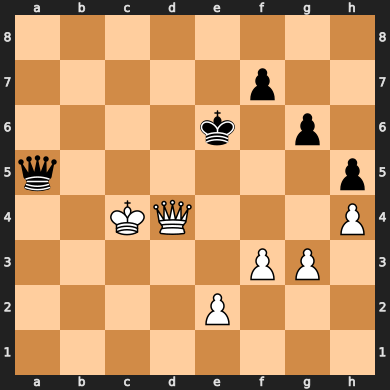

FEN: 8/5p2/4k1p1/q6p/2KQ3P/5PP1/4P3/8 b - - 0 58
Average Error: 44.934799999999996
Blunder Move: a5c7
Best Move: a5a6
Player: Black
To Move: Black
Event: FIDE World Championship Match 1969
White: Petrosian, Tigran V
Black: Spassky, Boris V.
Round: 2
Result: 1/2-1/2
WhiteElo: N/A
BlackElo: N/A
Opening: Tarrasch Defense: Classical Variation, Spassky Variation
File: analysis_pgns_test/4c6eS6SH---1969 Petrosian vs. Spassky .pgn


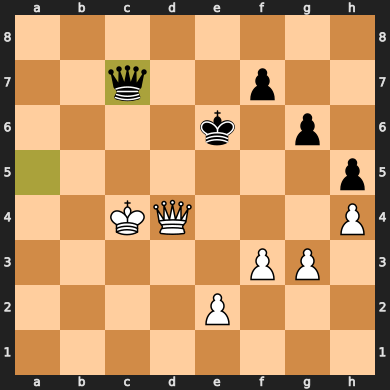

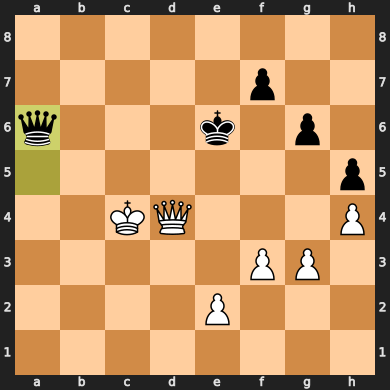

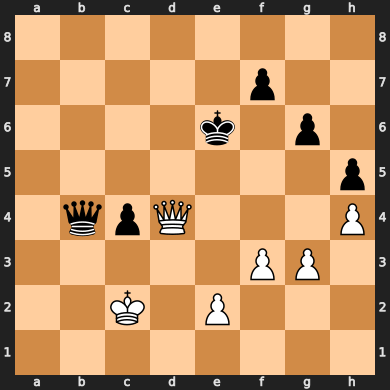

FEN: 8/5p2/4k1p1/7p/1qpQ3P/5PP1/2K1P3/8 b - - 15 56
Average Error: 30.777826086956527
Blunder Move: b4a4
Best Move: b4b3
Player: Black
To Move: Black
Event: FIDE World Championship Match 1969
White: Petrosian, Tigran V
Black: Spassky, Boris V.
Round: 2
Result: 1/2-1/2
WhiteElo: N/A
BlackElo: N/A
Opening: Tarrasch Defense: Classical Variation, Spassky Variation
File: analysis_pgns_test/4c6eS6SH---1969 Petrosian vs. Spassky .pgn


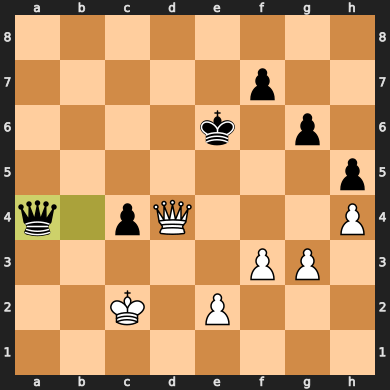

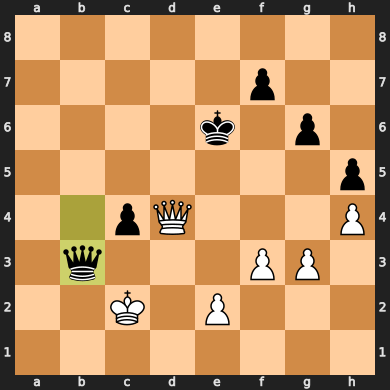

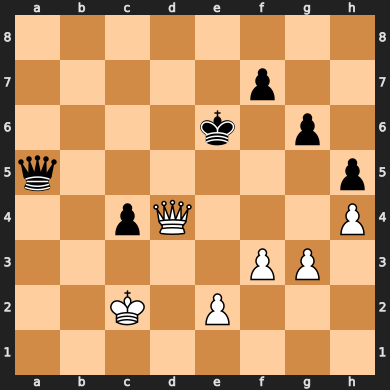

FEN: 8/5p2/4k1p1/q6p/2pQ3P/5PP1/2K1P3/8 b - - 9 53
Average Error: 27.509999999999994
Blunder Move: a5b5
Best Move: a5a4
Player: Black
To Move: Black
Event: FIDE World Championship Match 1969
White: Petrosian, Tigran V
Black: Spassky, Boris V.
Round: 2
Result: 1/2-1/2
WhiteElo: N/A
BlackElo: N/A
Opening: Tarrasch Defense: Classical Variation, Spassky Variation
File: analysis_pgns_test/4c6eS6SH---1969 Petrosian vs. Spassky .pgn


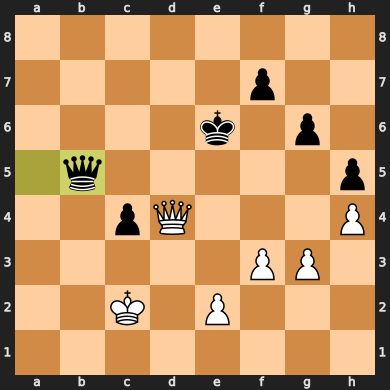

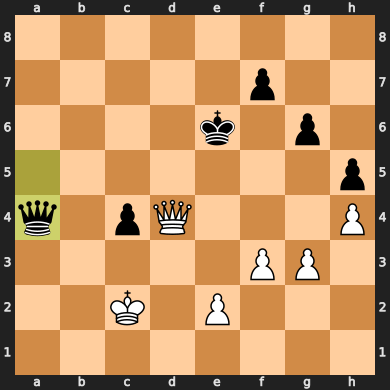

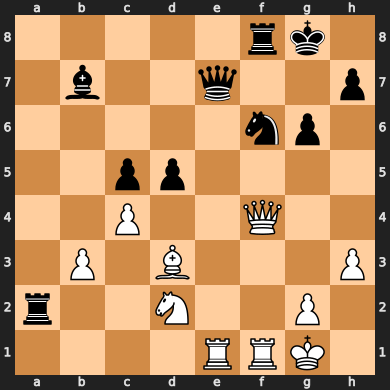

FEN: 5rk1/1b2q2p/5np1/2pp4/2P2Q2/1P1B3P/r2N2P1/4RRK1 b - - 3 24
Average Error: 24.377173913043475
Blunder Move: e7g7
Best Move: f6h5
Player: Black
To Move: Black
Event: FIDE World Championship Match 1969
White: Spassky, Boris V.
Black: Petrosian, Tigran V
Round: 1
Result: 0-1
WhiteElo: N/A
BlackElo: N/A
Opening: Sicilian Defense: Kan Variation, Modern Variation
File: analysis_pgns_test/4c6eS6SH---1969 Petrosian vs. Spassky .pgn


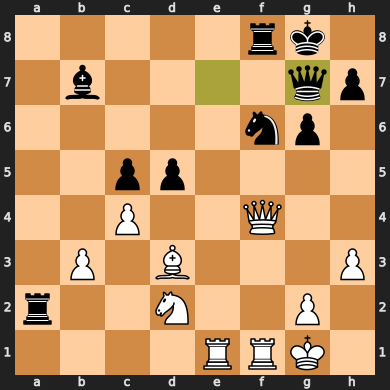

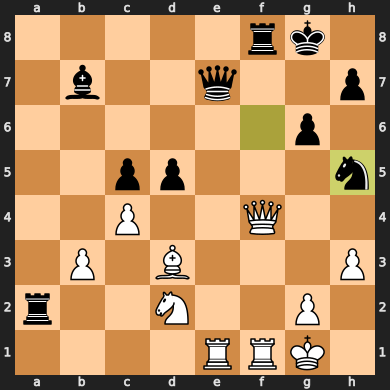

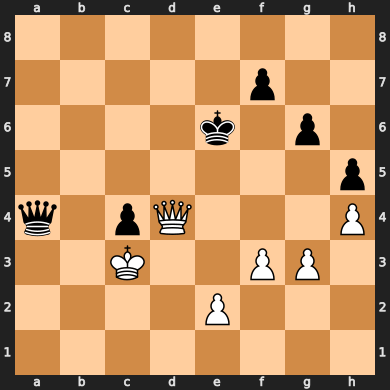

FEN: 8/5p2/4k1p1/7p/q1pQ3P/2K2PP1/4P3/8 b - - 17 57
Average Error: 22.091
Blunder Move: a4a5
Best Move: a4a1
Player: Black
To Move: Black
Event: FIDE World Championship Match 1969
White: Petrosian, Tigran V
Black: Spassky, Boris V.
Round: 2
Result: 1/2-1/2
WhiteElo: N/A
BlackElo: N/A
Opening: Tarrasch Defense: Classical Variation, Spassky Variation
File: analysis_pgns_test/4c6eS6SH---1969 Petrosian vs. Spassky .pgn


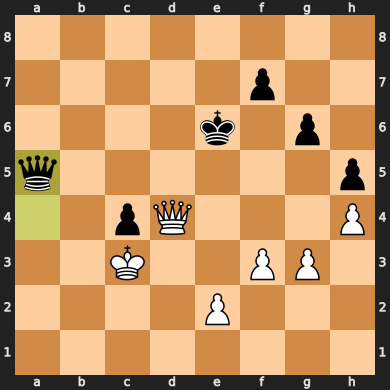

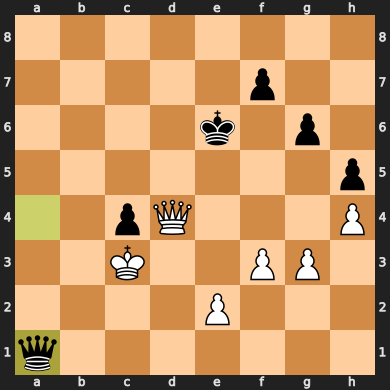

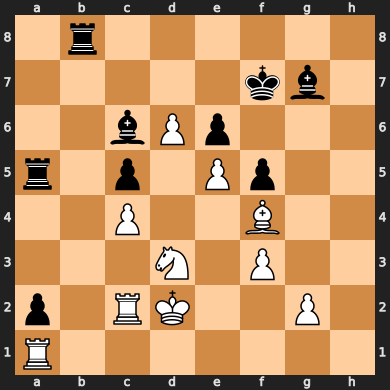

FEN: 1r6/5kb1/2bPp3/r1p1Pp2/2P2B2/3N1P2/p1RK2P1/R7 b - - 8 31
Average Error: 5.23421052631579
Blunder Move: b8a8
Best Move: b8b1
Player: Black
To Move: Black
Event: FIDE World Championship Match 1986
White: Karpov, Anatoly
Black: Kasparov, Garry
Round: 5
Result: 1-0
WhiteElo: 2705
BlackElo: 2740
Opening: Grünfeld Defense: Brinckmann Attack
File: analysis_pgns_test/4S5UuAGn---1986 Karpov vs. Kasparov III.pgn


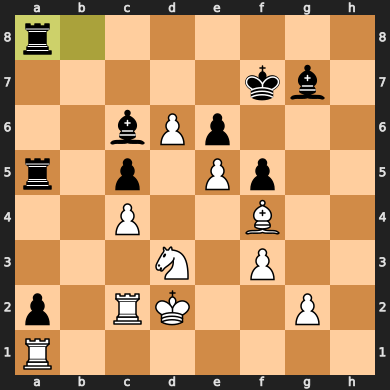

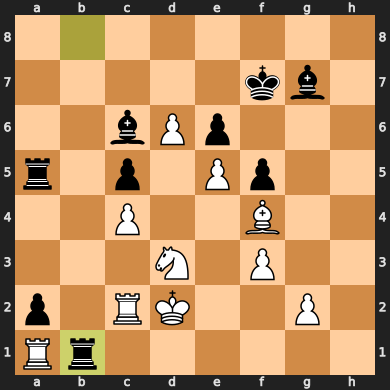

Image display complete.


In [5]:
# Import necessary libraries for image generation
from IPython.display import display, Image


# Function to save board image with annotations using svgwrite
def save_board_image_with_svgwrite(board, move=None, output_file="board.png"):
    svg_data = chess.svg.board(board, lastmove=move)
    svg_path = output_file.replace(".png", ".svg")

    # Save the SVG file
    with open(svg_path, "w") as svg_file:
        svg_file.write(svg_data)

    # Convert SVG to PNG using rsvg-convert
    subprocess.run(["rsvg-convert", "-o", output_file, svg_path])


# Function to highlight a move on the board
def highlight_move_with_svgwrite(board, move, output_file="highlighted_board.png"):
    if move in board.legal_moves:
        board.push(move)
        save_board_image_with_svgwrite(board, move, output_file)
        board.pop()  # Revert the move
    else:
        print(f"Illegal move {move} in position {board.fen()}")


# Function to generate images for all positions and save them with detailed filenames
def generate_images_for_positions(json_file, output_dir="chess_images"):
    with open(json_file, "r") as file:
        data = json.load(file)

    os.makedirs(output_dir, exist_ok=True)

    for event, details in data.items():
        for i, position in enumerate(details):
            fen = position["FEN"]
            move = position["Move"]
            best_move = position["Best Move"]
            event_name = position["Event"].replace(" ", "_").replace("/", "_")
            player = position["Player"]

            board = chess.Board(fen)

            # Generate initial board state image
            initial_image_path = os.path.join(output_dir, f"{event_name}_pos_{i + 1}_initial.png")
            save_board_image_with_svgwrite(board, output_file=initial_image_path)
            position["Initial Image"] = initial_image_path

            # Highlight the blunder move
            blunder_image_path = os.path.join(output_dir, f"{event_name}_pos_{i + 1}_blunder.png")
            highlight_move_with_svgwrite(board, chess.Move.from_uci(move), output_file=blunder_image_path)
            position["Blunder Image"] = blunder_image_path

            # Highlight the best move
            correct_image_path = os.path.join(output_dir, f"{event_name}_pos_{i + 1}_correct.png")
            highlight_move_with_svgwrite(board, chess.Move.from_uci(best_move), output_file=correct_image_path)
            position["Correct Move Image"] = correct_image_path

            print(f"Generated images for position {i + 1}/{len(details)} in event {event}")

    # Save updated data with image paths back to JSON
    with open(json_file, "w") as file:
        json.dump(data, file, indent=4)


print("Generating images for tricky positions...")
generate_images_for_positions("positions_with_errors.json")
generate_images_for_positions("positions_with_errors_maia.json")
print("Image generation complete.")


# Part for Displaying the Generated Images and Detailed Information

def display_generated_images(json_file, num_positions=5):
    with open(json_file, "r") as file:
        data = json.load(file)

    positions = []
    for event, details in data.items():
        positions.extend(details)

    # Sort positions by average error
    sorted_positions = sorted(positions, key=lambda x: x["Average Error"], reverse=True)

    for i, position in enumerate(sorted_positions[:num_positions]):
        fen = position["FEN"]
        avg_error = position["Average Error"]
        move = position["Move"]
        best_move = position["Best Move"]
        initial_image = position["Initial Image"]
        blunder_image = position["Blunder Image"]
        correct_image = position["Correct Move Image"]

        display(Image(filename=initial_image))
        print(f"FEN: {fen}")
        print(f"Average Error: {avg_error}")
        print(f"Blunder Move: {move}")
        print(f"Best Move: {best_move}")
        print(f"Player: {position['Player']}")
        print(f"To Move: {position['To Move']}")
        print(f"Event: {position['Event']}")
        print(f"White: {position['White']}")
        print(f"Black: {position['Black']}")
        print(f"Round: {position['Round']}")
        print(f"Result: {position['Result']}")
        print(f"WhiteElo: {position['WhiteElo']}")
        print(f"BlackElo: {position['BlackElo']}")
        print(f"Opening: {position['Opening']}")
        print(f"File: {position['File']}")
        display(Image(filename=blunder_image))
        display(Image(filename=correct_image))
        time.sleep(1)  # Delay for better viewing


print("Displaying tricky positions with images...")
display_generated_images("positions_with_errors.json", num_positions=5)
display_generated_images("positions_with_errors_maia.json", num_positions=5)
print("Image display complete.")
